# M1 Coursework - Question 4

In [13]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from tabulate import tabulate


from tensorflow.keras.datasets import mnist

from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

In [14]:
# Import initial data set from mnist
# x_train_val - will be split into training and validation sets
(x_train_val, y_train_val), (x_test, y_test) = mnist.load_data()

# Determine how many parameter values are in the data set
num_params = len(np.unique(y_test))

# Normalise the data
x_train_val = x_train_val / 255
x_test = x_test / 255

# Set the data type to float32
x_train_val = x_train_val.astype('float32')
x_test = x_test.astype('float32')

# Randomly shuffle data to ensure even distribution of labels
# Shuffle 60,000 data set
indices_train_val = np.arange(len(x_train_val))
np.random.shuffle(indices_train_val)
x_train_val = x_train_val[indices_train_val]
y_train_val = y_train_val[indices_train_val]

# Shuffle 10,000 data set
indices_test = np.arange(len(x_test))
np.random.shuffle(indices_test)
x_test = x_test[indices_test]
y_test = y_test[indices_test]

# Split test_val data into training and validation sets()
split_index = int(0.8 * len(x_train_val)) 
# 80 % going to training set
x_train = x_train_val[:split_index] 
y_train = y_train_val[:split_index]
# 20 % going to validation set
x_val = x_train_val[split_index:]
y_val = y_train_val[split_index:]

Item 17805/48000 from x_train
Label: 7


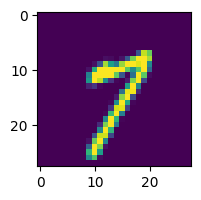

In [15]:
# Print example initial data and labels - randomly selected
plot_index = np.random.randint(0, len(x_train))
print(f"Item {plot_index}/{len(x_train)} from x_train")
print(f'Label: {y_train[plot_index]}')
plt.figure(figsize=(2, 2))
plt.imshow(x_train[plot_index])
plt.show()

In [16]:
# Create v stack input data 
train_double_size = 100000
val_double_size = 15000
test_double_size = 15000

# Generate random indices for the double data set
# Vectorised sampling with replacement
train_double_indices =  [np.random.randint(0, x_train.shape[0], train_double_size), np.random.randint(0, x_train.shape[0], train_double_size)]

val_double_indices =  [np.random.randint(0, x_val.shape[0], val_double_size), np.random.randint(0, x_val.shape[0], val_double_size)]

test_double_indices =  [np.random.randint(0, x_test.shape[0], test_double_size), np.random.randint(0, x_test.shape[0], test_double_size)]


# Generate their corresponding images and labels at these indices

x_train_double = np.concatenate((x_train[train_double_indices[0]], x_train[train_double_indices[1]]), axis=1) 
y_train_double = np.add(y_train[train_double_indices[0]], y_train[train_double_indices[1]])

x_val_double = np.concatenate((x_val[val_double_indices[0]], x_val[val_double_indices[1]]), axis=1)
y_val_double = np.add(y_val[val_double_indices[0]], y_val[val_double_indices[1]])

x_test_double = np.concatenate((x_test[test_double_indices[0]], x_test[test_double_indices[1]]), axis=1)
y_test_double = np.add(y_test[test_double_indices[0]], y_test[test_double_indices[1]])

# Store the top and bottom images individually as these will be used in sequential testing
x_train_double_top = x_train[train_double_indices[0]]
x_train_double_bottom = x_train[train_double_indices[1]]

y_train_double_top = y_train[train_double_indices[0]]
y_train_double_bottom = y_train[train_double_indices[1]]

x_val_double_top = x_val[val_double_indices[0]]
x_val_double_bottom = x_val[val_double_indices[1]]

y_val_double_top = y_val[val_double_indices[0]]
y_val_double_bottom = y_val[val_double_indices[1]]

x_test_double_top = x_test[test_double_indices[0]]
x_test_double_bottom = x_test[test_double_indices[1]]

y_test_double_top = y_test[test_double_indices[0]]
y_test_double_bottom = y_test[test_double_indices[1]]



100000


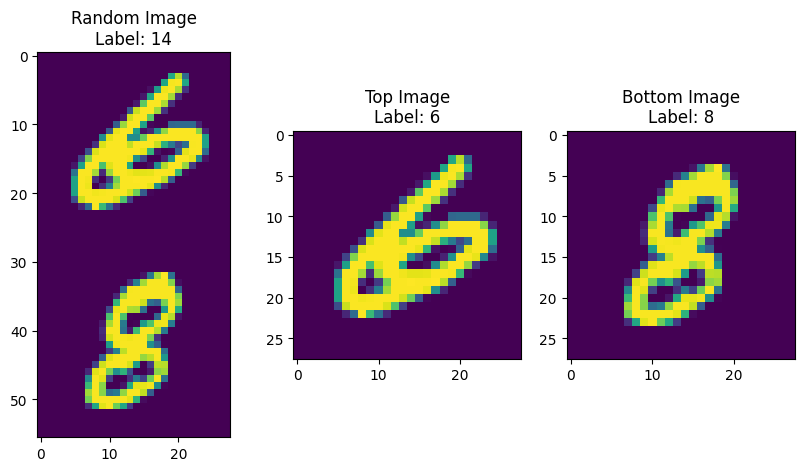

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Select a random index
print(x_train_double.shape[0])
random_index = np.random.randint(0, x_train_double.shape[0])

# Display the images
plt.figure(figsize=(10, 5))

# Random image
plt.subplot(1, 3, 1)
plt.title(f"Random Image\nLabel: {y_train_double[random_index]}")
plt.imshow(x_train_double[random_index])  # Assuming the images are 28x28 and concatenated along axis 1

# Top image
plt.subplot(1, 3, 2)
plt.title(f"Top Image\nLabel: {y_train_double_top[random_index]}")
plt.imshow(x_train_double_top[random_index])

# Bottom image
plt.subplot(1, 3, 3)
plt.title(f"Bottom Image\nLabel: {y_train_double_bottom[random_index]}")
plt.imshow(x_train_double_bottom[random_index])

plt.show()

In [18]:
# Use the one-hot encoding for the labels
num_param_single = len(np.unique(y_train))
y_train = to_categorical(y_train, num_param_single)
y_val = to_categorical(y_val, num_param_single)
y_test = to_categorical(y_test, num_param_single)

num_params_double = len(np.unique(y_train_double))
y_train_double = to_categorical(y_train_double, num_params_double)
y_val_double = to_categorical(y_val_double, num_params_double)
y_test_double = to_categorical(y_test_double, num_params_double)

## Sequential Classifier
### Train the model on MNIST Data

In [19]:
# Define input and output shapes
input_shape = x_train.shape[1:]  
output_shape = y_train.shape[1]  # Number of output classes (10 for MNIST)

# Define the logistic regression model for single 28x28 images
model_single = Sequential([
    Input(shape=input_shape),  
    Flatten(),                 
    Dense(output_shape, activation='softmax')
])

# Compile the model with Adam optimizer
model_single.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_accuracy',       
    patience=3,               
    restore_best_weights=True
)

# Train the model with early stopping
history = model_single.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=15,
    batch_size=64,
    callbacks=[early_stopping] 
)

# Save the model in Results folder
model_single.save('Results/Logistic_regression_sequential.keras')

Epoch 1/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.7676 - loss: 0.9169 - val_accuracy: 0.8968 - val_loss: 0.3711
Epoch 2/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.9031 - loss: 0.3510 - val_accuracy: 0.9069 - val_loss: 0.3194
Epoch 3/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.9130 - loss: 0.3131 - val_accuracy: 0.9137 - val_loss: 0.3013
Epoch 4/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.9196 - loss: 0.2926 - val_accuracy: 0.9146 - val_loss: 0.2950
Epoch 5/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.9217 - loss: 0.2789 - val_accuracy: 0.9173 - val_loss: 0.2875
Epoch 6/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.9230 - loss: 0.2738 - val_accuracy: 0.9193 - val_loss: 0.2840
Epoch 7/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.9242 - loss: 0.2672 - val_accuracy: 0.9209 - val_loss: 0.2790
Epoch 8/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.9285 - loss: 0.2555 - val_ac

In [20]:
predictions_test_top = model_single.predict(x_test_double_top)
predictions_test_bottom = model_single.predict(x_test_double_bottom)

# Initialize the combined probabilities for 0–18
num_samples = predictions_test_top.shape[0]
combined_test_predictions = np.zeros((num_samples, 19))

# Convolve probabilities for each sample - combines two probabilities of 0-9 to adding result of 0-18
for i in range(num_samples):
    combined_test_predictions[i] = np.convolve(predictions_test_top[i], predictions_test_bottom[i])

# Find the index of the maximum value in the combined probabilities
combined_test_predictions_value = np.argmax(combined_test_predictions, axis=1)
y_test_double_values = np.argmax(y_test_double, axis=1)

# Calculate the accuracy
accuracy_sequential = accuracy_score(y_test_double_values, combined_test_predictions_value)
print(f"Accuracy: {accuracy_sequential:.4f}")

# Generate the classification report as a dictionary
report_sequential = classification_report(y_test_double_values, combined_test_predictions_value, output_dict=True)

# Prepare data for tabulation
table_data_sequential = []
for label, metrics in report_sequential.items():
    if label.isdigit():  # Include only class-specific metrics
        table_data_sequential.append([
            int(label),  # Class label
            f"{metrics['precision']:.4f}",
            f"{metrics['recall']:.4f}",
            f"{metrics['f1-score']:.4f}",
        ])

# Add overall accuracy as a separate row
table_data_sequential.append(["Overall Accuracy", "-", "-", f"{accuracy_sequential:.4f}"])

# Create tabulated string
headers = ["Class", "Precision", "Recall", "F1-Score"]
table_sequential_report = tabulate(table_data_sequential, headers=headers, tablefmt="grid")

# Print the table
print(table_sequential_report)



469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Accuracy: 0.8599
+------------------+-------------+----------+------------+
| Class            | Precision   | Recall   |   F1-Score |
+==================+=============+==========+============+
| 0                | 0.9250      | 0.9610   |     0.9427 |
+------------------+-------------+----------+------------+
| 1                | 0.9379      | 0.9441   |     0.941  |
+------------------+-------------+----------+------------+
| 2                | 0.8868      | 0.9059   |     0.8962 |
+------------------+-------------+----------+------------+
| 3                | 0.8993      | 0.8823   |     0.8907 |
+------------------+-------------+----------+------------+
| 4                | 0.8826      | 0.8805   |     0.8816 |
+------------------+-------------+----------+------------+
| 5                | 0.8849      | 0.8740   |     0.8794 |
+------------------+-------------+----------+------------+
| 6             

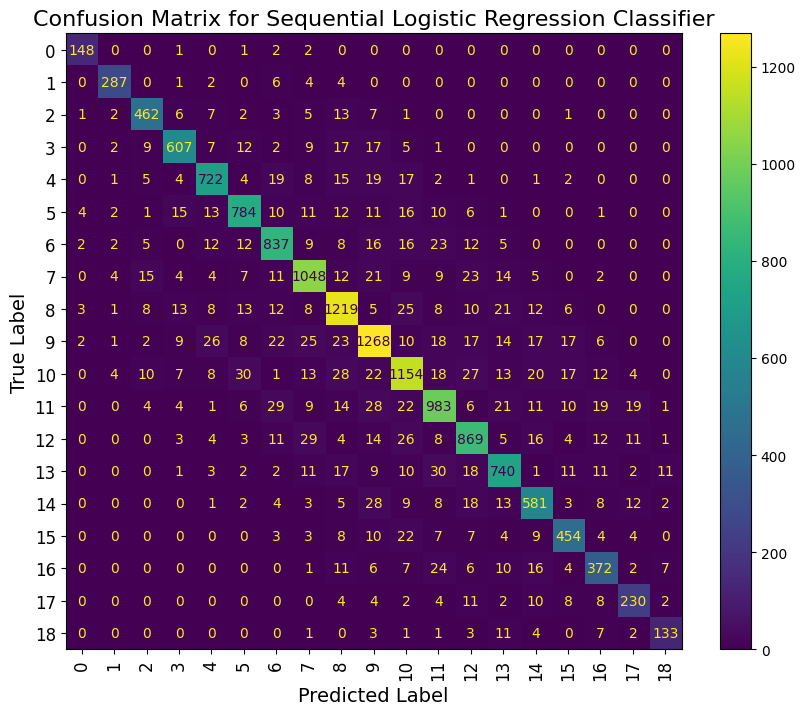

In [21]:
# Generate a confusion matrix
conf_matrix_single = confusion_matrix(y_test_double_values, combined_test_predictions_value)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_single, display_labels=np.unique(y_test_double_values))

# Plot the confusion matrix 
fig, ax = plt.subplots(figsize=(10, 8)) 
disp.plot(cmap="viridis", xticks_rotation="vertical",
          ax=ax, colorbar=True)

plt.title("Confusion Matrix for Sequential Logistic Regression Classifier", fontsize=16)
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

## Combined Classifer
### Train the model on MNIST Data

In [22]:
# Define input and output shapes
input_shape = x_train_double.shape[1:]  
output_shape = y_train_double.shape[1]  # Number of output classes (19 for MNIST)

# Define the logistic regression model for single 28x28 images
model_double = Sequential([
    Input(shape=input_shape),  
    Flatten(),                 
    Dense(output_shape, activation='softmax')
])

# Compile the model with Adam optimizer
model_double.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_accuracy',       
    patience=3,               
    restore_best_weights=True
)

# Train the model with early stopping
history = model_double.fit(
    x_train_double, y_train_double,
    validation_data=(x_val_double, y_val_double),
    epochs=15,
    batch_size=64,
    callbacks=[early_stopping] 
)

# Save the model in Results folder
model_double.save('Results/Logistic_regression_combined.keras')

Epoch 1/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - accuracy: 0.1687 - loss: 2.4461 - val_accuracy: 0.2087 - val_loss: 2.2233
Epoch 2/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - accuracy: 0.2287 - loss: 2.1899 - val_accuracy: 0.2157 - val_loss: 2.1928
Epoch 3/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - accuracy: 0.2394 - loss: 2.1515 - val_accuracy: 0.2283 - val_loss: 2.1735
Epoch 4/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - accuracy: 0.2488 - loss: 2.1278 - val_accuracy: 0.2256 - val_loss: 2.1728
Epoch 5/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - accuracy: 0.2516 - loss: 2.1206 - val_accuracy: 0.2261 - val_loss: 2.1840
Epoch 6/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - accuracy: 0.2561 - loss: 2.1071 - val_accuracy: 0.2261 - val_loss: 2.1824


In [23]:
y_test_double_pred = model_double.predict(x_test_double)

# Find the index of the maximum value in the combined probabilities
y_test_double_pred_value = np.argmax(y_test_double_pred, axis=1)
y_test_double_values = np.argmax(y_test_double, axis=1)

# Calculate the accuracy
accuracy_combined = accuracy_score(y_test_double_values, y_test_double_pred_value)
print(f"Accuracy: {accuracy_combined:.4f}")

# Generate the classification report as a dictionary to be converted to a table
report_combined = classification_report(y_test_double_values, y_test_double_pred_value, output_dict=True)

# Prepare data for tabulation
table_data = []
for label, metrics in report_combined.items():
    if label.isdigit():  # Include only class-specific metrics
        table_data.append([
            int(label),  # Class label
            f"{metrics['precision']:.4f}",
            f"{metrics['recall']:.4f}",
            f"{metrics['f1-score']:.4f}",])

# Add overall accuracy at the end as a new row
table_data.append(["Overall Accuracy", "-", "-", f"{accuracy_combined:.4f}"])

# Create tabulated string
headers = ["Class", "Precision", "Recall", "F1-Score"]
table_combined_report = tabulate(table_data, headers=headers, tablefmt="grid")

# Print the table
print(table_combined_report)

469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Accuracy: 0.2318
+------------------+-------------+----------+------------+
| Class            | Precision   | Recall   |   F1-Score |
+==================+=============+==========+============+
| 0                | 0.7114      | 0.9286   |     0.8056 |
+------------------+-------------+----------+------------+
| 1                | 0.6641      | 0.5592   |     0.6071 |
+------------------+-------------+----------+------------+
| 2                | 0.4043      | 0.5922   |     0.4805 |
+------------------+-------------+----------+------------+
| 3                | 0.2650      | 0.2500   |     0.2573 |
+------------------+-------------+----------+------------+
| 4                | 0.2491      | 0.1768   |     0.2068 |
+------------------+-------------+----------+------------+
| 5                | 0.2127      | 0.1048   |     0.1404 |
+------------------+-------------+----------+------------+
| 6                | 0.1465      | 0.1262   |     0.1356 

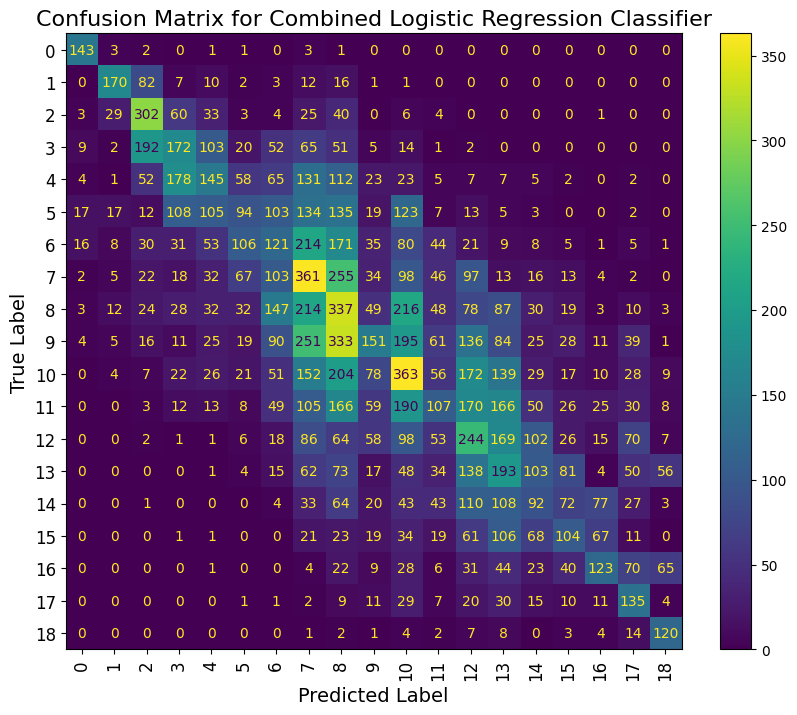

In [24]:
# Generate a confusion matrix
conf_matrix_double= confusion_matrix(y_test_double_values, y_test_double_pred_value)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_double, display_labels=np.unique(y_test_double_values))

# Plot the confusion matrix 
fig, ax = plt.subplots(figsize=(10, 8)) 
disp.plot(cmap="viridis", xticks_rotation="vertical",
          ax=ax, colorbar=True)

plt.title("Confusion Matrix for Combined Logistic Regression Classifier", fontsize=16)
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()